In [ ]:
using Pkg
using Base.Iterators
using BSON: @load, @save
using CSV
# using CuArrays
using DataFrames
using DataStructures: OrderedDict
using Dates
using Flux
using Flux: binarycrossentropy, logitbinarycrossentropy, crossentropy
using JSON
using LinearAlgebra
import MLDataUtils: shuffleobs, getobs, splitobs, stratifiedobs, RandomBatches
using MLDataPattern
using Printf
using PyPlot
using Random
using Statistics

using FluxGoodies

ENV["COLUMNS"] = 1000
# CuArrays.allowscalar(false)

Experimental code.

In [3]:
function import_csv(fname, split::AbstractFloat = 0.8)
    df = CSV.read(fname)
    n = size(df, 1)
    npassengers = (size(df, 2) - 4) ÷ 6
    println("samples: $(n), #passengers: $npassengers")
    df = df[:, Symbol.(vcat(["onboard_count", "lat", "lon"], [["pickup_$(i)_lat",
            "pickup_$(i)_lon", "pickup_$(i)_maxtime",
            "dropoff_$(i)_lat",
            "dropoff_$(i)_lon", "dropoff_$(i)_maxtime"] for i in 1:npassengers]..., ["feasible"]))]
    desc = "VGA data for $npassengers passengers"
    Random.seed!(1234)
    itrn, itst = first.(parentindices.(splitobs(shuffleobs(df), split)))
    rawdata = Dataset(df, desc, [:train => itrn, :test => itst])
    dtrans = tonumerical(rawdata, :, :T => Dict(:standardize => false))
    data = transform(rawdata, dtrans, Matrix{Float32})
    data, rawdata, dtrans
end

import_csv (generic function with 2 methods)

In [6]:
model_dir="../../../../carsharing-tsp/exp/car4_test1024_512_256_gpu/"    
@load joinpath(model_dir, "model.bson") cpumodel
model = cpumodel |> gpu

MLP(Chain(Dense(27, 1024, NNlib.relu), Dense(1024, 512, NNlib.relu), Dense(512, 256, NNlib.relu), Dense(256, 1)))

In [7]:
function logcmatrix(logY, T)
    C = σ.(logY) .> 0.5
    t, f = T .== 1, T .== 0
    TP = sum(T[t] .== C[t])
    FP = sum(T[t] .!= C[t])
    TN = sum(T[f] .== C[f])
    FN = sum(T[f] .!= C[f])
    [TP FP; FN TN]
end

cm = logcmatrix(model(X_tst), T_tst)
cm ./ sum(cm)

2×2 Array{Float64,2}:
 0.696735  0.01923 
 0.07868   0.205355

In [8]:
mean(T_trn)

0.71562f0

In [9]:
t = σ.(cpu(model(X_tst))).data;

In [10]:
t

1×200000 Array{Float32,2}:
 0.968691  0.0367181  0.971925  0.988065  …  0.999333  0.99315  0.999895

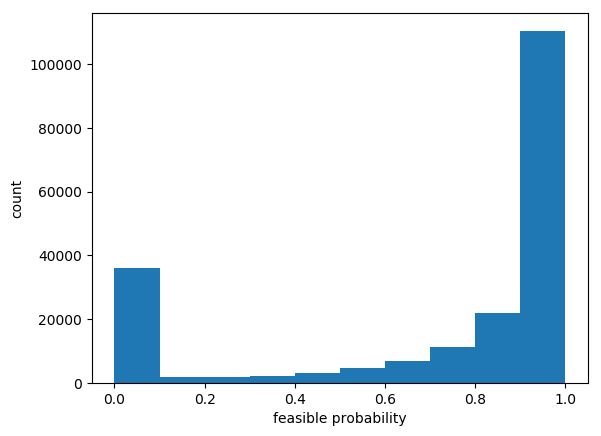

PyObject Text(24.0, 0.5, 'count')

In [12]:
plt.hist(reshape(t, :))
plt.xlabel("feasible probability")
plt.ylabel("count")